# Preprocessing

Import python modules

In [1]:
import pandas as pd
import numpy as np
import pycombat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Load gene expression and metadata

In [45]:
import_expression_filepath = "data/processed/expression_brain_only.csv" 
import_metadata_filepath = "data/processed/metadata_brain_only.csv"
export_expression_filepath = "data/processed/expression_gbm_healthy.csv" 
export_metadata_filepath = "data/processed/metadata_gbm_healthy.csv"

In [36]:
gene_expression_df = pd.read_csv(
    import_expression_filepath,
    # index_col='sample_id'
)
print("Expression Shape:", gene_expression_df.shape)
display(gene_expression_df.head())

Expression Shape: (60498, 1840)


,sample_id,TCGA-19-1787-01,TCGA-S9-A7J2-01,GTEX-13QIC-0011-R1a-SM-5O9CJ,TCGA-E1-A7YI-01,TCGA-06-5412-01,TCGA-DU-7302-01,TCGA-DU-A7TI-01,GTEX-N7MS-2526-SM-26GMA,GTEX-N7MS-2526-SM-26GMR,...,TCGA-06-0745-01,GTEX-13G51-0011-R6b-SM-5LZX4,TCGA-TM-A84B-01,GTEX-YFC4-0011-R10a-SM-4SOK5,TCGA-DU-A76O-01,GTEX-13112-0011-R4b-SM-5DUXL,GTEX-1313W-0011-R1b-SM-5EQ4A,TCGA-CS-4944-01,TCGA-HT-7603-01,GTEX-Q2AG-2826-SM-2HMJQ
0,ENSG00000242268,-9.9658,0.2998,-9.9658,-0.4521,-4.2934,-2.5479,-0.6193,-0.5756,-2.8262,...,-1.2481,-1.0262,1.1117,-0.6416,-9.9658,-2.5479,-1.5522,-9.9658,-9.9658,0.0440
1,ENSG00000259041,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
2,ENSG00000270112,-3.8160,-3.0469,-1.8314,-0.7346,0.1519,0.9115,-2.6349,3.7204,1.7489,...,1.2147,-0.8599,1.8242,1.2576,-6.5064,-1.0862,0.6880,-4.2934,1.0642,2.5852
3,ENSG00000167578,5.2998,4.8881,6.4989,5.7632,6.1687,5.6329,5.8709,6.0086,2.1894,...,6.0330,5.6789,4.6809,6.5322,6.2263,5.5100,6.1258,6.6567,6.8560,5.8110
4,ENSG00000278814,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658


In [37]:
metadata_df = pd.read_csv(
    import_metadata_filepath,
    # index_col='sample_id'
)

print("\nMetadata Shape:", metadata_df.shape)
display(metadata_df.head())


Metadata Shape: (1839, 7)


,sample_id,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study
0,TCGA-06-0152-02,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Recurrent Tumor,Male,TCGA
1,TCGA-06-0171-02,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Recurrent Tumor,Male,TCGA
2,TCGA-06-0190-02,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Recurrent Tumor,Male,TCGA
3,TCGA-19-1389-02,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Recurrent Tumor,Male,TCGA
4,TCGA-14-0736-02,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Recurrent Tumor,Male,TCGA


## Prepare samples

### label mapping
- 1 - healthy.
- 2 - Lower Grade Glioma.
- 3 - Glioblastoma Multiforme.

In [38]:
healthy_metadata = metadata_df[(
    (metadata_df['_sample_type'] == 'Normal Tissue')
)].copy()
print(f"Created Healthy group with {len(healthy_metadata)} samples.")
healthy_metadata['label'] = 1

unhealthy_metadata = metadata_df[(
    (metadata_df['_sample_type'] == 'Primary Tumor')
)]
print(f"Created Unhealthy group with {len(unhealthy_metadata)} samples.")

unhealthy_gbm_metadata = unhealthy_metadata[
    unhealthy_metadata['primary disease or tissue'] == 'Glioblastoma Multiforme'
].copy()
print(f"Created Unhealthy GBM group with {len(unhealthy_gbm_metadata)} samples.")
unhealthy_gbm_metadata['label'] = 3


combined_metadata_df = pd.concat([healthy_metadata, unhealthy_gbm_metadata])
combined_metadata_df.info()


Created Healthy group with 1152 samples.
Created Unhealthy group with 660 samples.
Created Unhealthy GBM group with 152 samples.
<class 'pandas.core.frame.DataFrame'>
Index: 1304 entries, 687 to 164
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sample_id                  1304 non-null   object
 1   detailed_category          1304 non-null   object
 2   primary disease or tissue  1304 non-null   object
 3   _primary_site              1304 non-null   object
 4   _sample_type               1304 non-null   object
 5   _gender                    1304 non-null   object
 6   _study                     1304 non-null   object
 7   label                      1304 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 91.7+ KB


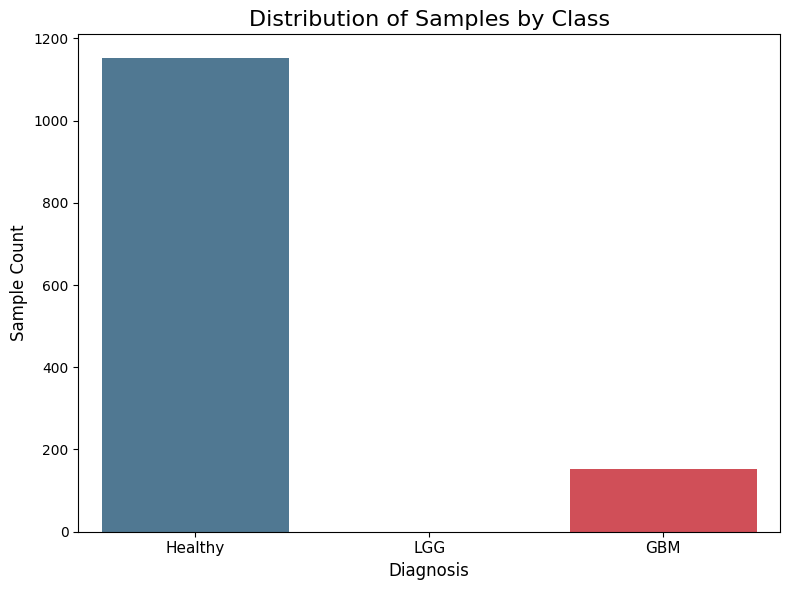

In [39]:
# --- 1. Create a copy and map labels for plotting ---
plot_df = combined_metadata_df.copy()

# Define the new string labels
label_map = {
    1: 'Healthy',
    2: 'LGG',
    3: 'GBM'
}
plot_df['Diagnosis'] = plot_df['label'].map(label_map)

# --- 2. Create the plot ---
plt.figure(figsize=(8, 6))

# Define the order we want the bars to appear in
plot_order = ['Healthy', 'LGG', 'GBM']

# Define a clear color palette
plot_palette = {
    'Healthy': '#457B9D', 
    'LGG': '#A8DADC', 
    'GBM': '#E63946'
}

sns.countplot(
    x='Diagnosis',
    data=plot_df,
    order=plot_order,
    palette=plot_palette,
    hue='Diagnosis', # We still map hue to get the colors
    legend=False
)

plt.title('Distribution of Samples by Class', fontsize=16)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

In [40]:
combined_metadata_df

,sample_id,detailed_category,primary disease or tissue,_primary_site,_sample_type,_gender,_study,label
687,GTEX-13SLW-0011-R4b-SM-5S2W2,Brain - Amygdala,Brain - Amygdala,Brain,Normal Tissue,Male,GTEX,1
688,GTEX-13RTJ-0011-R4b-SM-5PNX1,Brain - Amygdala,Brain - Amygdala,Brain,Normal Tissue,Male,GTEX,1
689,GTEX-WVLH-0011-R4A-SM-3MJFS,Brain - Amygdala,Brain - Amygdala,Brain,Normal Tissue,Male,GTEX,1
690,GTEX-147GR-0011-R4a-SM-5S2V2,Brain - Amygdala,Brain - Amygdala,Brain,Normal Tissue,Male,GTEX,1
691,GTEX-13N2G-0011-R4b-SM-5MR54,Brain - Amygdala,Brain - Amygdala,Brain,Normal Tissue,Male,GTEX,1
...,...,...,...,...,...,...,...,...
160,TCGA-12-0616-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Female,TCGA,3
161,TCGA-12-3653-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Female,TCGA,3
162,TCGA-06-2569-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Female,TCGA,3
163,TCGA-06-5416-01,Glioblastoma Multiforme,Glioblastoma Multiforme,Brain,Primary Tumor,Female,TCGA,3


In [41]:
b_samples_to_keep = combined_metadata_df['sample_id'].tolist()

print(f"Total samples to keep for analysis: {len(b_samples_to_keep)}")

filtered_genes = gene_expression_df[
    gene_expression_df.columns.intersection(b_samples_to_keep)
].copy()

print(f"Filtered expression matrix shape: {filtered_genes.shape}")

print("\n--- Pipeline B Complete ---")
print(f"Final `gene` matrix shape: {filtered_genes.shape}")
display(filtered_genes.head())

Total samples to keep for analysis: 1304
Filtered expression matrix shape: (60498, 1304)

--- Pipeline B Complete ---
Final `gene` matrix shape: (60498, 1304)


,TCGA-19-1787-01,GTEX-13QIC-0011-R1a-SM-5O9CJ,TCGA-06-5412-01,GTEX-N7MS-2526-SM-26GMA,GTEX-N7MS-2526-SM-26GMR,GTEX-NPJ7-0011-R6a-SM-2I3G7,GTEX-132Q8-3026-SM-5PNVG,TCGA-16-0846-01,TCGA-12-5299-01,GTEX-NPJ7-2726-SM-2I3FT,...,GTEX-1192X-3226-SM-5987D,GTEX-ZVZQ-0011-R5b-SM-57WDC,GTEX-13X6K-0011-R8b-SM-5PNZ4,GTEX-12ZZZ-0011-R6b-SM-5EQ5B,TCGA-06-0745-01,GTEX-13G51-0011-R6b-SM-5LZX4,GTEX-YFC4-0011-R10a-SM-4SOK5,GTEX-13112-0011-R4b-SM-5DUXL,GTEX-1313W-0011-R1b-SM-5EQ4A,GTEX-Q2AG-2826-SM-2HMJQ
0,-9.9658,-9.9658,-4.2934,-0.5756,-2.8262,-0.5973,-9.9658,-0.8863,-2.8262,-2.8262,...,-3.3076,-1.6394,-1.2142,-1.6394,-1.2481,-1.0262,-0.6416,-2.5479,-1.5522,0.0440
1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
2,-3.8160,-1.8314,0.1519,3.7204,1.7489,-0.8084,0.6608,-1.2481,-1.0559,0.0718,...,2.1476,-1.3548,0.4657,-0.3752,1.2147,-0.8599,1.2576,-1.0862,0.6880,2.5852
3,5.2998,6.4989,6.1687,6.0086,2.1894,5.4350,6.0503,6.1851,5.5732,5.5629,...,5.6832,4.9444,6.2521,4.9704,6.0330,5.6789,6.5322,5.5100,6.1258,5.8110
4,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658


## Store data for ease of use 

In [46]:
labels_df = combined_metadata_df.set_index('sample_id').copy()
final_labels_df = labels_df[['label']]

# We add index_label='sample_id' here too for consistency
final_labels_df.to_csv(export_metadata_filepath, index_label='sample_id')
print(f"Labels saved to: {export_metadata_filepath}")

Labels saved to: data/processed/metadata_gbm_healthy.csv


In [47]:
gene_T = filtered_genes.T

scaler = StandardScaler()
gene_scaled_array = scaler.fit_transform(gene_T)

# --- 4. Convert Scaled Data Back to DataFrame ---
gene_scaled_df = pd.DataFrame(
    gene_T,
    index=gene_T.index,
    columns=gene_T.columns
)

# We add index_label='sample_id' to name the first column
gene_scaled_df.to_csv(export_expression_filepath, index_label='sample_id')
print(f"Scaled data saved to: {export_expression_filepath}")

Scaled data saved to: data/processed/expression_gbm_healthy.csv
